In [1]:
import glob
import os
import sys
from base64 import b64decode
from io import BytesIO
from PIL import Image

from transformers import (
    AutoTokenizer,
    CLIPImageProcessor,
    AutoProcessor,
    TrainingArguments,
    Trainer,
    AutoModelForCausalLM
)
import datasets
import torch
from torch.utils.data import Dataset
import yaml
import deepspeed
import fire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from peft import LoraConfig, get_peft_config, get_peft_model


from heron.models.git_llm.git_opt import GitOPTForCausalLM, GitOPTConfig
from heron.models.git_llm.git_llama import GitLlamaForCausalLM, GitLlamaConfig

[2023-08-24 10:48:09,558] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
sys.path.append('..')
from heron.models.utils import load_model, apply_lora_model, load_pretrained_weight
from heron.models.prepare_processors import get_processor
from heron.datasets.m3it_datasets import M3ITDataset

# Functions

In [3]:
def generate_text(model, data):
    eos_token_id_list = [
        supervised_test_dataset.processor.tokenizer.pad_token_id,
        supervised_test_dataset.processor.tokenizer.eos_token_id,
    ]
    with torch.no_grad():
        out = model.generate(**data, max_length=256, do_sample=False, temperature=0., eos_token_id=eos_token_id_list)
        return supervised_test_dataset.processor.tokenizer.batch_decode(out)

# Load configs

In [4]:
device_id = 0
config_file = f"../projects/opt/exp001.yml"

# get config
with open(config_file, "r") as i_:
    config = yaml.safe_load(i_)

# Load a pretrained model

In [5]:
model = load_model(config)

# lora
if config["use_lora"]:
    model = apply_lora_model(model, config)

# load pretrained weight
weight_path = glob.glob(f'../output/opt/exp001/checkpoint*/pytorch*.bin')
load_pretrained_weight(model, weight_path)

model.eval()
model.to(f"cuda:{device_id}")
print("Complete preparing an eval model")

You are using a model of type opt to instantiate a model of type git_opt. This is not supported for all configurations of models and can yield errors.
Some weights of GitOPTForCausalLM were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['image_encoder.vision_model.encoder.layers.1.layer_norm2.bias', 'image_encoder.vision_model.encoder.layers.8.self_attn.v_proj.bias', 'image_encoder.vision_model.encoder.layers.1.layer_norm2.weight', 'image_encoder.vision_model.encoder.layers.9.layer_norm1.bias', 'image_encoder.vision_model.encoder.layers.6.mlp.fc1.weight', 'image_encoder.vision_model.encoder.layers.5.layer_norm1.weight', 'image_encoder.vision_model.encoder.layers.3.self_attn.v_proj.weight', 'image_encoder.vision_model.encoder.layers.4.self_attn.v_proj.weight', 'image_encoder.vision_model.encoder.layers.9.self_attn.out_proj.weight', 'image_encoder.vision_model.encoder.layers.7.layer_norm2.bias', 'image_encoder.vision_model.encoder.layers.8.laye

Complete preparing an eval model


# Inference

textcap has no test set.
vqa-v2 has no test set.
--------------------
['</s>##Instruction: Provide a concise and informative caption for the image, focusing on the primary subjects. ##Question:  ##Answer: ttttttttttttttttttttttttttt"""""""""""""""drdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdrdr                                                                       ']
A man with a red helmet on a small moped on a dirt road.


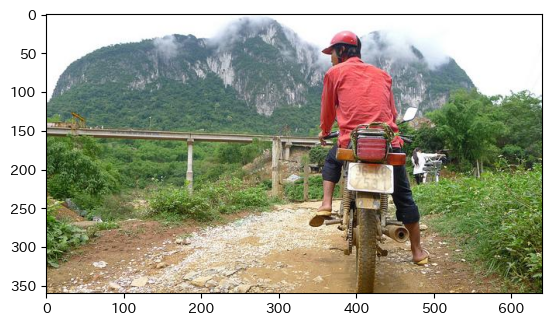

--------------------
['</s>##Instruction: Write a succinct description of the image, capturing its main components, the relationships between them, and any notable details. ##Question:  ##Answer: tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt']
A giraffe lays down in an enclosure.


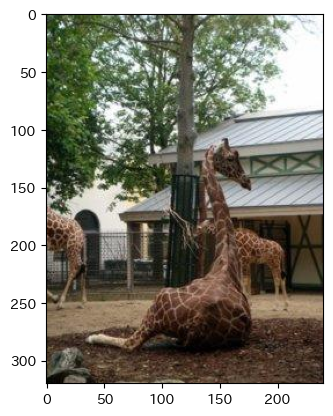

--------------------
['</s>##Instruction: Describe the image briefly. ##Question:  ##Answer:                               Others Y                                                                                                                                                                                                              ']
there are three girls sitting in floats in the ocean


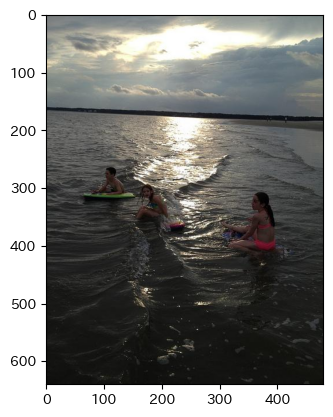

--------------------
['</s>##Instruction: Write a clear description of the image, make sure the key features are well covered. ##Question:  ##Answer: uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuoru uorororororororororororororororororororororororororororororor']
A man is holding a device playing a video game.


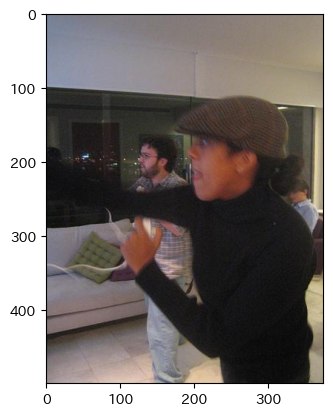

--------------------
['</s>##Instruction: Offer a succinct explanation of the picture presented. ##Question:  ##Answer: ishishishishishishishishishishishishishishishishishishishishishishishishishishishishishishishishishish"""""""""""""""""""""evereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverevereverever']
A bagel sandwich with scrambled egg an

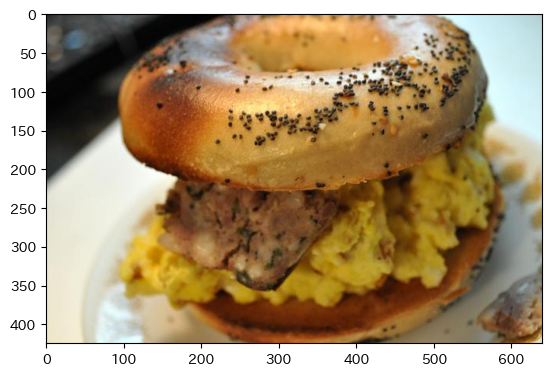

In [9]:
dataset_config_path = os.path.join("../", config["dataset_config_path"])
with open(dataset_config_path, "r") as f:
    dataset_config = yaml.safe_load(f)

processor = get_processor(config["settings"]["model_name"], config["settings"]["vision_model_name"])
supervised_test_dataset = M3ITDataset.create(dataset_config, processor, "test", is_inference=True)

for i in range(0, len(supervised_test_dataset), len(supervised_test_dataset)//5):
    data, img, answer = supervised_test_dataset[i]
    for k in ["input_ids", "pixel_values", "attention_mask"]:
        data[k] = data[k].to(f"cuda:{device_id}")
    print('-'*20)
    print(generate_text(model, data))
    print(answer)
    plt.figure()
    plt.imshow(np.array(img))
    plt.show()
    plt.clf()
    plt.close()

--------------------
</s>##Instruction: Please answer the following question concletely. ##Question: What is unusual about this image? Explain precisely and concletely what he is doing? ##Answer: passpassnpassnpassnnnnnnnnnnnnnnnnnn"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""s"s"s"s"s"s"s"ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


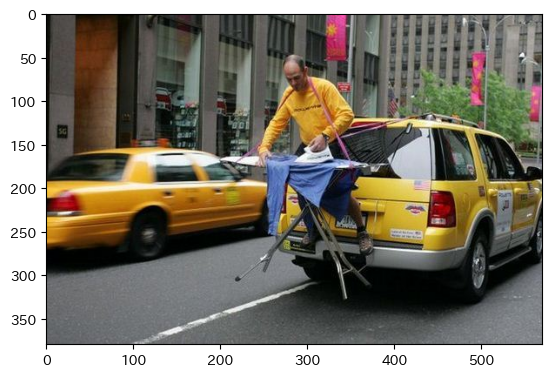

In [10]:
import requests

url = "https://www.barnorama.com/wp-content/uploads/2016/12/03-Confusing-Pictures.jpg"
image = Image.open(requests.get(url, stream=True).raw)

text = f"##Instruction: Please answer the following question concletely. ##Question: What is unusual about this image? Explain precisely and concletely what he is doing? ##Answer: "

data = supervised_test_dataset.processor(text, image, return_tensors="pt")
for k in ["input_ids", "pixel_values", "attention_mask"]:
    data[k] = data[k].to(f"cuda:{device_id}")

print('-'*20)
print(generate_text(model, data)[0])
plt.figure()
plt.imshow(np.array(image))
plt.show()
plt.clf()
plt.close()